In [1]:
import numpy as np

def preprocess(image_list):
    """ Normalize Image and Permute (N,H,W,C) to (N,C,H,W)
    Args:
      image_list: List of images (9000, 32, 32, 3)
    Returns:
      image_list: List of images (9000, 3, 32, 32)
    """
    image_list = np.array(image_list)
    image_list = np.transpose(image_list, (0, 3, 1, 2))
    image_list = (image_list / 255.0) * 2 - 1
    image_list = image_list.astype(np.float32)
    return image_list

from torch.utils.data import Dataset

class Image_Dataset(Dataset):
    def __init__(self, image_list):
        self.image_list = image_list
    def __len__(self):
        return len(self.image_list)
    def __getitem__(self, idx):
        images = self.image_list[idx]
        return images

In [2]:
##將訓練資料讀入，並且 preprocess。 之後我們將 preprocess 完的訓練資料變成我們需要的 dataset。
##請同學不要使用 valX 和 valY 來訓練。
from torch.utils.data import DataLoader

trainX = np.load('trainX_new.npy')
trainX_preprocessed = preprocess(trainX)
img_dataset = Image_Dataset(trainX_preprocessed)


In [3]:
##這邊提供一些有用的 functions。 一個是計算 model 參數量的（report 會用到），
##另一個是固定訓練的隨機種子（以便 reproduce）。

import random
import torch

def count_parameters(model, only_trainable=False):
    if only_trainable:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in model.parameters())

def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [4]:
##Model

import torch.nn as nn

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2)
        )
 
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 5, stride=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 9, stride=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 17, stride=1),
            nn.Tanh()
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x  = self.decoder(x1)
        return x1, x


In [5]:
##Training
##這個部分就是主要的訓練階段。 我們先將準備好的 dataset 當作參數餵給 dataloader。 將 dataloader、model、
##loss criterion、optimizer 都準備好之後，就可以開始訓練。 訓練完成後，我們會將 model 存下來。
import torch
from torch import optim

same_seeds(0)
model = AE().cuda() 
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

model.train()
n_epoch = 100

# 準備 dataloader, model, loss criterion 和 optimizer
img_dataloader = DataLoader(img_dataset, batch_size=64, shuffle=True)

epoch_loss = 0

# 主要的訓練過程
for epoch in range(n_epoch):
    epoch_loss = 0
    for data in img_dataloader:
        img = data
        img = img.cuda()
        
        output1, output = model(img)
        loss = criterion(output, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (epoch+1) % 10 == 0:
            torch.save(model.state_dict(), './checkpoint_{}.pth'.format(epoch+1))
        
        epoch_loss += loss.item()
            
    print('epoch [{}/{}], loss:{:.5f}'.format(epoch+1, n_epoch, epoch_loss))

# 訓練完成後儲存 model
torch.save(model.state_dict(), './last_checkpoint.pth')

epoch [1/100], loss:30.24671
epoch [2/100], loss:24.49412
epoch [3/100], loss:20.49728
epoch [4/100], loss:17.63873
epoch [5/100], loss:15.75676
epoch [6/100], loss:14.57789
epoch [7/100], loss:13.77095
epoch [8/100], loss:13.19298
epoch [9/100], loss:12.73910
epoch [10/100], loss:12.33854
epoch [11/100], loss:12.01339
epoch [12/100], loss:11.70447
epoch [13/100], loss:11.45516
epoch [14/100], loss:11.22852
epoch [15/100], loss:11.02543
epoch [16/100], loss:10.84238
epoch [17/100], loss:10.66412
epoch [18/100], loss:10.50576
epoch [19/100], loss:10.34905
epoch [20/100], loss:10.20341
epoch [21/100], loss:10.06144
epoch [22/100], loss:9.93527
epoch [23/100], loss:9.80492
epoch [24/100], loss:9.68517
epoch [25/100], loss:9.56882
epoch [26/100], loss:9.45303
epoch [27/100], loss:9.35874
epoch [28/100], loss:9.26288
epoch [29/100], loss:9.15159
epoch [30/100], loss:9.06386
epoch [31/100], loss:8.97846
epoch [32/100], loss:8.89415
epoch [33/100], loss:8.82560
epoch [34/100], loss:8.73985
ep

In [6]:
##Dimension Reduction & Clustering
import numpy as np

def cal_acc(gt, pred):
    """ Computes categorization accuracy of our task.
    Args:
      gt: Ground truth labels (9000, )
      pred: Predicted labels (9000, )
    Returns:
      acc: Accuracy (0~1 scalar)
    """
    # Calculate Correct predictions
    correct = np.sum(gt == pred)
    acc = correct / gt.shape[0]
    # 因為是 binary unsupervised clustering，因此取 max(acc, 1-acc)
    return max(acc, 1-acc)

import matplotlib.pyplot as plt

def plot_scatter(feat, label, savefig=None):
    """ Plot Scatter Image.
    Args:
      feat: the (x, y) coordinate of clustering result, shape: (9000, 2)
      label: ground truth label of image (0/1), shape: (9000,)
    Returns:
      None
    """
    X = feat[:, 0]
    Y = feat[:, 1]
    plt.scatter(X, Y, c = label)
    plt.legend(loc='best')
    if savefig is not None:
        plt.savefig(savefig)
    plt.show()
    return

In [7]:
##接著我們使用訓練好的 model，來預測 testing data 的類別。
##由於 testing data 與 training data 一樣，因此我們使用同樣的 dataset 來實作 dataloader。
##與 training 不同的地方在於 shuffle 這個參數值在這邊是 False。
##準備好 model 與 dataloader，我們就可以進行預測了。
##我們只需要 encoder 的結果（latents），利用 latents 進行 clustering 之後，就可以分類了。
import torch
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans

def inference(X, model, batch_size=256):
    X = preprocess(X)
    dataset = Image_Dataset(X)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    latents = []
    for i, x in enumerate(dataloader):
        x = torch.FloatTensor(x)
        vec, img = model(x.cuda())
        if i == 0:
            latents = vec.view(img.size()[0], -1).cpu().detach().numpy()
        else:
            latents = np.concatenate((latents, vec.view(img.size()[0], -1).cpu().detach().numpy()), axis = 0)
    print('Latents Shape:', latents.shape)
    return latents

def predict(latents):
    # First Dimension Reduction
    transformer = KernelPCA(n_components=200, kernel='rbf', n_jobs=-1)
    kpca = transformer.fit_transform(latents)
    print('First Reduction Shape:', kpca.shape)

    # # Second Dimesnion Reduction
    X_embedded = TSNE(n_components=2).fit_transform(kpca)
    print('Second Reduction Shape:', X_embedded.shape)

    # Clustering
    pred = MiniBatchKMeans(n_clusters=2, random_state=0).fit(X_embedded)
    pred = [int(i) for i in pred.labels_]
    pred = np.array(pred)
    return pred, X_embedded

def invert(pred):
    return np.abs(1-pred)

def save_prediction(pred, out_csv='prediction.csv'):
    with open(out_csv, 'w') as f:
        f.write('id,label\n')
        for i, p in enumerate(pred):
            f.write(f'{i},{p}\n')
    print(f'Save prediction to {out_csv}.')

# load model
model = AE().cuda()
model.load_state_dict(torch.load('./last_checkpoint.pth'))
model.eval()

# 準備 data
trainX = np.load('trainX_new.npy')

# 預測答案
latents = inference(X=trainX, model=model)
pred, X_embedded = predict(latents)

# 將預測結果存檔
save_prediction(pred, 'prediction.csv')

# 由於是 unsupervised 的二分類問題，我們只在乎有沒有成功將圖片分成兩群
# 如果上面的檔案上傳 kaggle 後正確率不足 0.5，只要將 label 反過來就行了
#save_prediction(invert(pred), 'prediction_invert.csv')


Latents Shape: (8500, 4096)


/home/ma-user/anaconda3/envs/Pytorch-1.0.0/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/ma-user/anaconda3/envs/Pytorch-1.0.0/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/ma-user/anaconda3/envs/Pytorch-1.0.0/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/ma-user/anaconda3/envs/Pytorch-1.0.0/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/ma-user/anaconda3/envs/Pytorch-1.0.0/lib/python3.6/site-pa

First Reduction Shape: (8500, 200)
Second Reduction Shape: (8500, 2)
Save prediction to prediction.csv.


Latents Shape: (500, 4096)


/home/ma-user/anaconda3/envs/Pytorch-1.0.0/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


First Reduction Shape: (500, 200)


No handles with labels found to put in legend.


Second Reduction Shape: (500, 2)
The clustering accuracy is: 0.69
The clustering result:


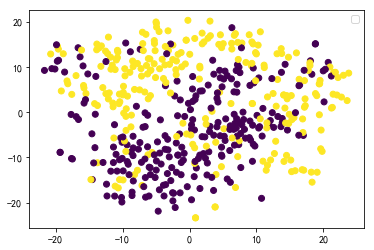

In [9]:
#Problem 1.b (作圖)
#將 val data 的降維結果 (embedding) 與他們對應的 label 畫出來。
valX = np.load('valX.npy')
valY = np.load('valY.npy')

# ==============================================
#  我們示範 basline model 的作圖，
#  report 請同學另外還要再畫一張 improved model 的圖。
# ==============================================
model.load_state_dict(torch.load('./last_checkpoint.pth'))
model.eval()
latents = inference(valX, model)
pred_from_latent, emb_from_latent = predict(latents)
acc_latent = cal_acc(valY, pred_from_latent)
print('The clustering accuracy is:', acc_latent)
print('The clustering result:')
plot_scatter(emb_from_latent, valY, savefig='p1_baseline.png')

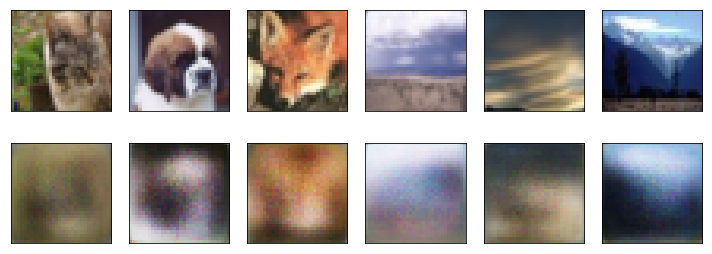

In [10]:
#Problem 2
#使用你 test accuracy 最高的 autoencoder，從 trainX 中，取出 index 1, 2, 3, 6, 7, 9 這 6 張圖片 
#畫出他們的原圖以及 reconstruct 之後的圖片。
import matplotlib.pyplot as plt
import numpy as np

# 畫出原圖
plt.figure(figsize=(10,4))
indexes = [1,2,3,6,7,9]
imgs = trainX[indexes,]
for i, img in enumerate(imgs):
    plt.subplot(2, 6, i+1, xticks=[], yticks=[])
    plt.imshow(img)

# 畫出 reconstruct 的圖
inp = torch.Tensor(trainX_preprocessed[indexes,]).cuda()
latents, recs = model(inp)
recs = ((recs+1)/2 ).cpu().detach().numpy()
recs = recs.transpose(0, 2, 3, 1)
for i, img in enumerate(recs):
    plt.subplot(2, 6, 6+i+1, xticks=[], yticks=[])
    plt.imshow(img)
  
plt.tight_layout()

In [13]:
##Problem 3
##在 autoencoder 的訓練過程中，至少挑選 10 個 checkpoints 請用 model 的 
## train reconstruction error 對 val accuracy 作圖 簡單說明你觀察到的現象
import os
import glob
checkpoints_list = sorted(glob.glob('checkpoint_*.pth'), key= lambda x: int(os.path.splitext(os.path.basename(x))[0].split('_')[-1]))

# load data
dataset = Image_Dataset(trainX_preprocessed)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

points = []
with torch.no_grad():
    for i, checkpoint in enumerate(checkpoints_list):
        print('[{}/{}] {}'.format(i+1, len(checkpoints_list), checkpoint))
        model.load_state_dict(torch.load(checkpoint))
        model.eval()
        err = 0
        n = 0
        for x in dataloader:
            x = x.cuda()
            _, rec = model(x)
            err += torch.nn.MSELoss(reduction='sum')(x, rec).item()
            n += x.flatten().size(0)
        print('Reconstruction error (MSE):', err/n)
        latents = inference(X=valX, model=model)
        pred, X_embedded = predict(latents)
        acc = cal_acc(valY, pred)
        print('Accuracy:', acc)
        points.append((err/n, acc))

[1/2] checkpoint_50.pth
Reconstruction error (MSE): 0.05839798796410654
Latents Shape: (500, 4096)


/home/ma-user/anaconda3/envs/Pytorch-1.0.0/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


First Reduction Shape: (500, 200)
Second Reduction Shape: (500, 2)
Accuracy: 0.696
[2/2] checkpoint_100.pth
Reconstruction error (MSE): 0.04678329895991905
Latents Shape: (500, 4096)


/home/ma-user/anaconda3/envs/Pytorch-1.0.0/lib/python3.6/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


First Reduction Shape: (500, 200)
Second Reduction Shape: (500, 2)
Accuracy: 0.7
